Type 2 Diabetes Hospital Readmission Data Science Project
by Likhitha Sindhu Geddam

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ========================= 
# 1. LOAD DATA
# =========================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv("data/diabetic_data.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")

LOADING DATA
Dataset shape: (101766, 50)

Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

First few rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Cauca

In [49]:
missing_summary = df.apply(lambda x: x.isin(['?', 'NA', 'N/A', 'na', 'n/a', 'null', 'Null']).sum())
print(missing_summary)

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [50]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].astype(str).unique())


Column: encounter_id
['2278392' '149190' '64410' ... '443854148' '443857166' '443867222']

Column: patient_nbr
['8222157' '55629189' '86047875' ... '140199494' '120975314' '175429310']

Column: race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']

Column: gender
['Female' 'Male' 'Unknown/Invalid']

Column: age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

Column: weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']

Column: admission_type_id
['6' '1' '2' '3' '4' '5' '8' '7']

Column: discharge_disposition_id
['25' '1' '3' '6' '2' '5' '11' '7' '10' '4' '14' '18' '8' '13' '12' '16'
 '17' '22' '23' '9' '20' '15' '24' '28' '19' '27']

Column: admission_source_id
['1' '7' '2' '4' '5' '6' '20' '3' '17' '8' '9' '14' '10' '22' '11' '25'
 '13']

Column: time_in_hospital
['1' '3' '2' '4' '5' '13' '12' '9' '7' '10' '6' '11' '8' '14']

Column: payer_code
['?' 'MC' 'MD' 

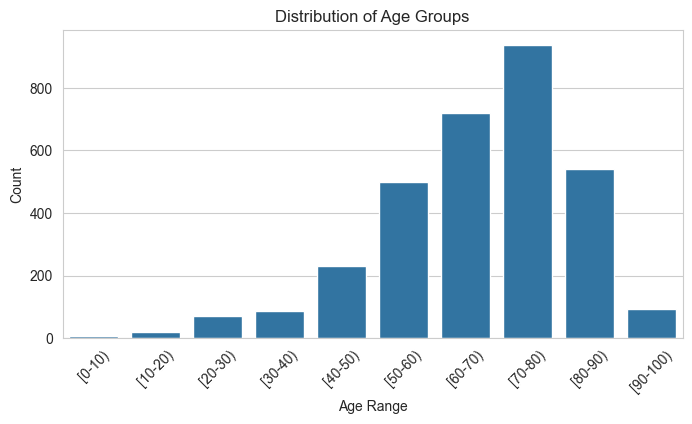

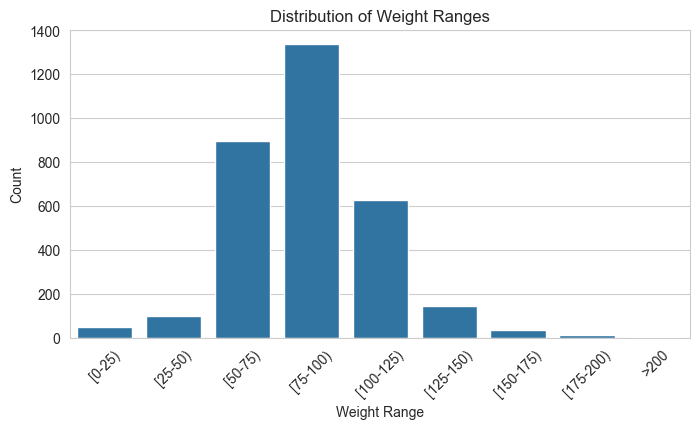

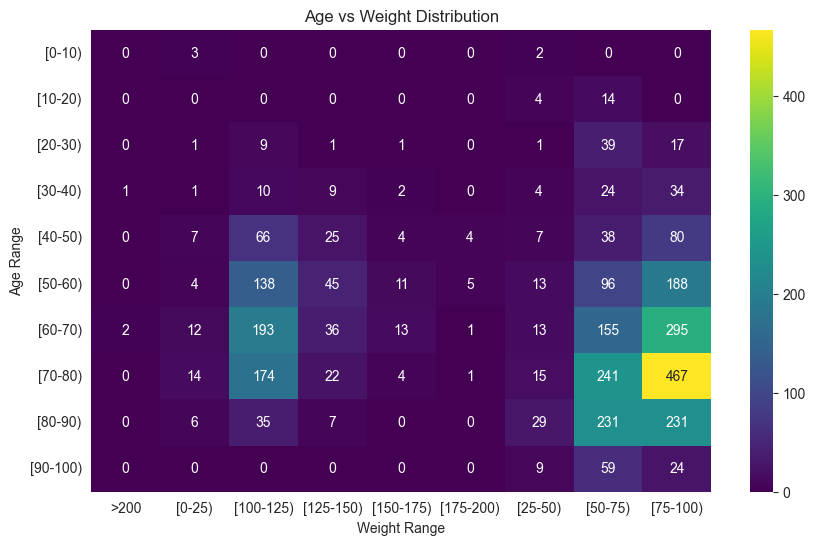

In [51]:
# Replace "?" with NaN
df = df.replace('?', pd.NA)

# Drop rows where age or weight is missing
df = df.dropna(subset=['age', 'weight'])

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='age', order=sorted(df['age'].unique()))
plt.title('Distribution of Age Groups')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='weight', order=[
    '[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)',
    '[125-150)', '[150-175)', '[175-200)', '>200'
])
plt.title('Distribution of Weight Ranges')
plt.xlabel('Weight Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Create a cross-tab (frequency table)
age_weight = pd.crosstab(df['age'], df['weight'])

plt.figure(figsize=(10,6))
sns.heatmap(age_weight, annot=True, fmt='d', cmap='viridis')
plt.title('Age vs Weight Distribution')
plt.xlabel('Weight Range')
plt.ylabel('Age Range')
plt.show()

gender
1    1648
2    1549
Name: count, dtype: Int64


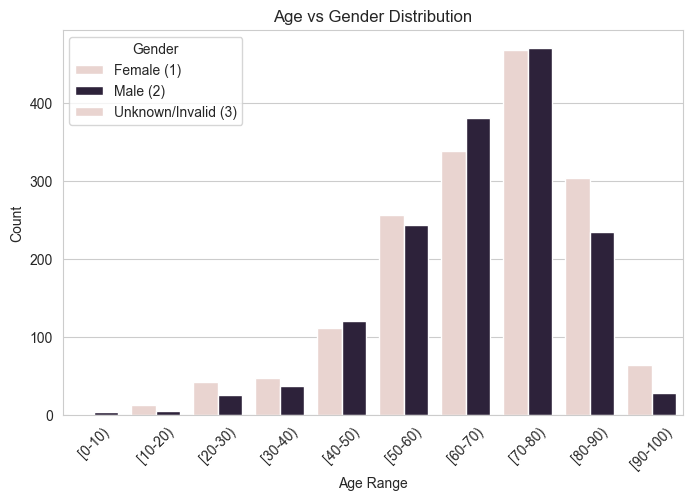

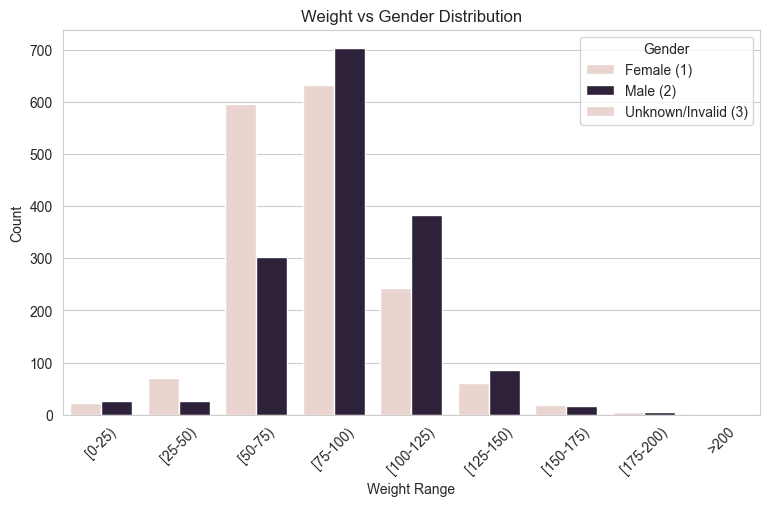

In [52]:
# Convert gender strings to lowercase and strip spaces
df['gender'] = df['gender'].str.lower().str.strip()

# Map to your numeric encoding
gender_map = {
    'female': 1,
    'male': 2,
    'unknown/invalid': 3  # match your data exactly
}

df['gender'] = df['gender'].map(gender_map).astype('Int64')

print(df['gender'].value_counts(dropna=False))

plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='age',
    hue='gender',
    order=sorted(df['age'].unique())
)
plt.title('Age vs Gender Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(
    title='Gender',
    labels=['Female (1)', 'Male (2)', 'Unknown/Invalid (3)']
)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(9,5))
sns.countplot(
    data=df,
    x='weight',
    hue='gender',
    order=['[0-25)', '[25-50)', '[50-75)', '[75-100)', 
           '[100-125)', '[125-150)', '[150-175)', 
           '[175-200)', '>200']
)
plt.title('Weight vs Gender Distribution')
plt.xlabel('Weight Range')
plt.ylabel('Count')
plt.legend(
    title='Gender',
    labels=['Female (1)', 'Male (2)', 'Unknown/Invalid (3)']
)
plt.xticks(rotation=45)
plt.show()


['>30' 'NO' '<30']


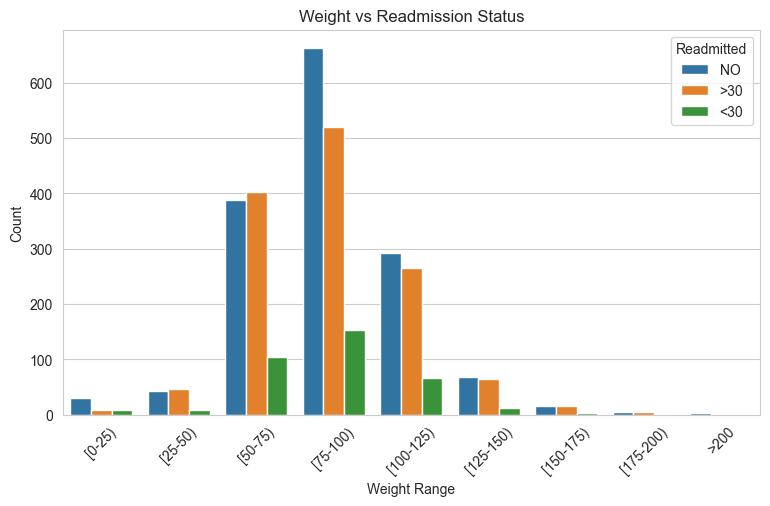

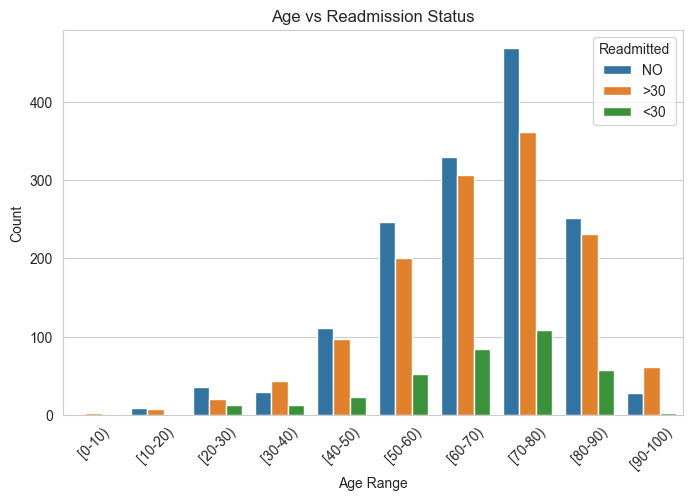

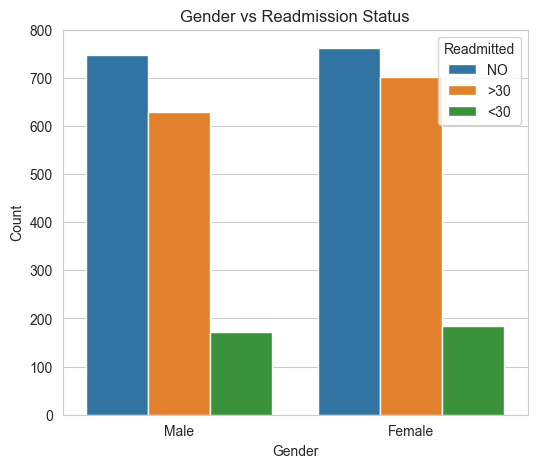

In [53]:
# Replace missing placeholders
df = df.replace(['?', 'NA', 'na', 'None', ''], pd.NA)

# Standardize readmitted column
df['readmitted'] = df['readmitted'].str.strip().str.upper()

# Check unique values
print(df['readmitted'].unique())

plt.figure(figsize=(9,5))
sns.countplot(
    data=df,
    x='weight',
    hue='readmitted',
    order=['[0-25)', '[25-50)', '[50-75)', '[75-100)', 
           '[100-125)', '[125-150)', '[150-175)', 
           '[175-200)', '>200']
)
plt.title('Weight vs Readmission Status')
plt.xlabel('Weight Range')
plt.ylabel('Count')
plt.legend(title='Readmitted', labels=['NO', '>30', '<30'])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='age',
    hue='readmitted',
    order=sorted(df['age'].unique())
)
plt.title('Age vs Readmission Status')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(title='Readmitted', labels=['NO', '>30', '<30'])
plt.xticks(rotation=45)
plt.show()

gender_labels = {1: 'Female', 2: 'Male', 3: 'Unknown/Invalid'}
df['gender_label'] = df['gender'].map(gender_labels)

plt.figure(figsize=(6,5))
sns.countplot(
    data=df,
    x='gender_label',
    hue='readmitted'
)
plt.title('Gender vs Readmission Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Readmitted', labels=['NO', '>30', '<30'])
plt.show()

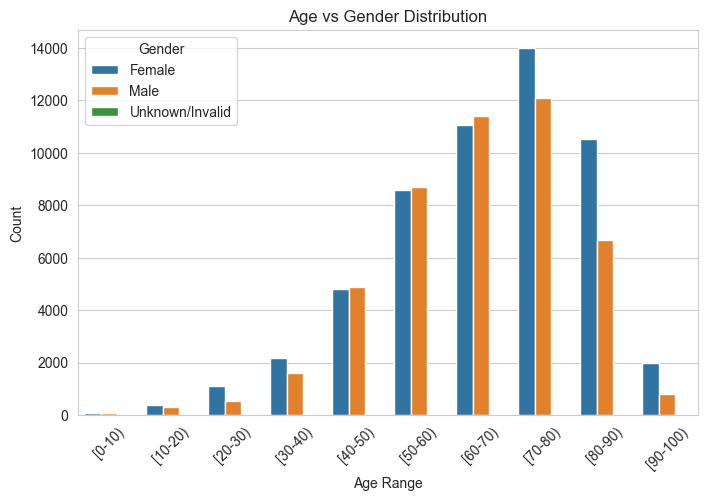

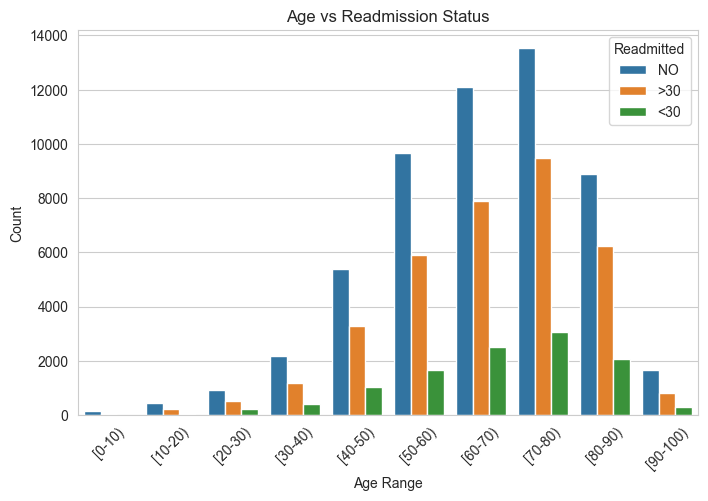

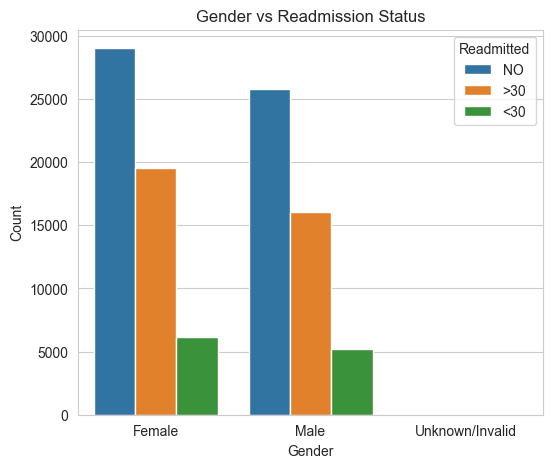

In [55]:
df = pd.read_csv("data/diabetic_data.csv")

df_new = df.drop('weight', axis=1)

# Clean column names (just in case)
df_new.columns = df_new.columns.str.lower().str.strip()

# Clean and standardize text values
df_new['age'] = df_new['age'].astype(str).str.strip()
df_new['readmitted'] = df_new['readmitted'].astype(str).str.strip().str.upper()
df_new['gender'] = df_new['gender'].astype(str).str.strip().str.lower()

# Map gender values to numbers
gender_map = {
    'female': 1,
    'male': 2,
    'unknown/invalid': 3
}
df_new['gender'] = df_new['gender'].map(gender_map).astype('Int64')

# Add readable gender label for plots
gender_labels = {1: 'Female', 2: 'Male', 3: 'Unknown/Invalid'}
df_new['gender_label'] = df_new['gender'].map(gender_labels)

plt.figure(figsize=(8,5))
sns.countplot(
    data=df_new,
    x='age',
    hue='gender_label',
    order=sorted(df['age'].unique())
)
plt.title('Age vs Gender Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(
    data=df_new,
    x='age',
    hue='readmitted',
    order=sorted(df['age'].unique())
)
plt.title('Age vs Readmission Status')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(title='Readmitted', labels=['NO', '>30', '<30'])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,5))
sns.countplot(
    data=df_new,
    x='gender_label',
    hue='readmitted',
    order=['Female', 'Male', 'Unknown/Invalid']
)
plt.title('Gender vs Readmission Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Readmitted', labels=['NO', '>30', '<30'])
plt.show()

            Medical_Specialty  Count
0                           ?  49949
1            InternalMedicine  14635
2            Emergency/Trauma   7565
3      Family/GeneralPractice   7440
4                  Cardiology   5352
5             Surgery-General   3099
6                  Nephrology   1613
7                 Orthopedics   1400
8  Orthopedics-Reconstructive   1233
9                 Radiologist   1140


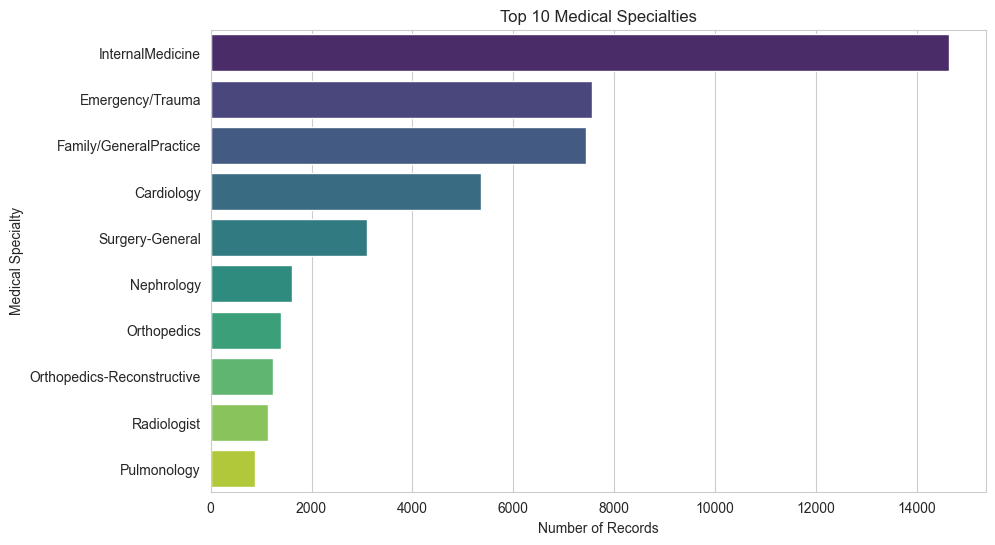

In [56]:
df = pd.read_csv("data/diabetic_data.csv")

df['medical_specialty'].value_counts(dropna=False)

df['medical_specialty'].value_counts(dropna=False).sort_index()

medical_counts = (
    df['medical_specialty']
    .value_counts(dropna=False)
    .reset_index()
)
medical_counts.columns = ['Medical_Specialty', 'Count']

print(medical_counts.head(10))  # show top 10

df['medical_specialty'] = df['medical_specialty'].replace('?', pd.NA)

df['medical_specialty'].value_counts(dropna=False)

top_specialties = df['medical_specialty'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_specialties.values,
    y=top_specialties.index,
    palette="viridis"
)
plt.title('Top 10 Medical Specialties')
plt.xlabel('Number of Records')
plt.ylabel('Medical Specialty')
plt.show()


          medical_specialty readmitted  count
0      AllergyandImmunology        <30      3
1      AllergyandImmunology        >30      3
2      AllergyandImmunology         NO      1
3            Anesthesiology        <30      1
4            Anesthesiology        >30      3
5            Anesthesiology         NO      8
6  Anesthesiology-Pediatric        <30      1
7  Anesthesiology-Pediatric        >30      5
8  Anesthesiology-Pediatric         NO     13
9                Cardiology        <30    425


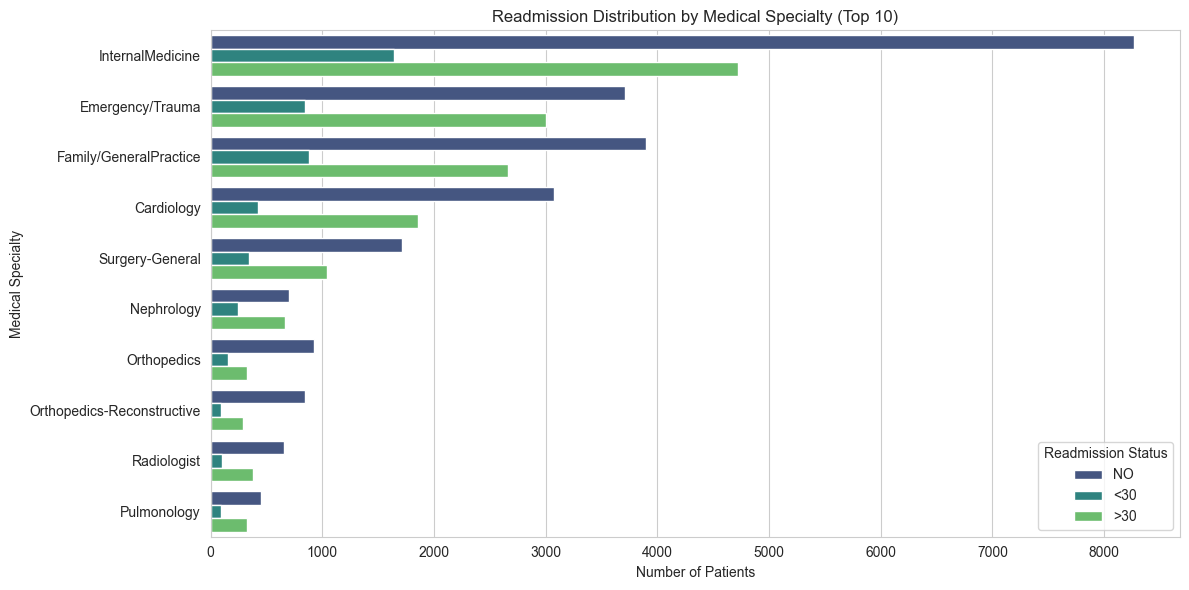

ValueError: cannot insert medical_specialty, already exists

In [57]:
readmit_counts = (
    df.groupby(['medical_specialty', 'readmitted'])
      .size()
      .reset_index(name='count')
      .sort_values(['medical_specialty', 'readmitted'])
)
print(readmit_counts.head(10))

# Get top 10 specialties by total count
top_specialties = (
    df['medical_specialty']
    .value_counts()
    .head(10)
    .index
)

# Filter data
filtered_df = df[df['medical_specialty'].isin(top_specialties)]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=filtered_df,
    y='medical_specialty',
    hue='readmitted',
    order=top_specialties,
    palette='viridis'
)
plt.title('Readmission Distribution by Medical Specialty (Top 10)')
plt.xlabel('Number of Patients')
plt.ylabel('Medical Specialty')
plt.legend(title='Readmission Status')
plt.tight_layout()
plt.show()

# Compute percentages
readmit_pct = (
    df.groupby(['medical_specialty', 'readmitted'])
      .size()
      .groupby(level=0)
      .apply(lambda x: 100 * x / x.sum())
      .reset_index(name='percentage')
)

# Plot top 10 specialties
top_specialties = df['medical_specialty'].value_counts().head(10).index
filtered_pct = readmit_pct[readmit_pct['medical_specialty'].isin(top_specialties)]

plt.figure(figsize=(12,6))
sns.barplot(
    data=filtered_pct,
    y='medical_specialty',
    x='percentage',
    hue='readmitted',
    palette='viridis'
)
plt.title('Readmission Percentage by Medical Specialty (Top 10)')
plt.xlabel('Percentage of Patients')
plt.ylabel('Medical Specialty')
plt.legend(title='Readmission Status')
plt.tight_layout()
plt.show()

In [59]:
df = pd.read_csv("data/diabetic_data.csv")
print(df['diag_1'].value_counts())
print(df['diag_2'].value_counts())
print(df['diag_3'].value_counts())

diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
833       1
391       1
690       1
10        1
V51       1
Name: count, Length: 717, dtype: int64
diag_2
276    6752
428    6662
250    6071
427    5036
401    3736
       ... 
123       1
884       1
V60       1
843       1
927       1
Name: count, Length: 749, dtype: int64
diag_3
250    11555
401     8289
276     5175
428     4577
427     3955
       ...  
14         1
750        1
370        1
671        1
971        1
Name: count, Length: 790, dtype: int64


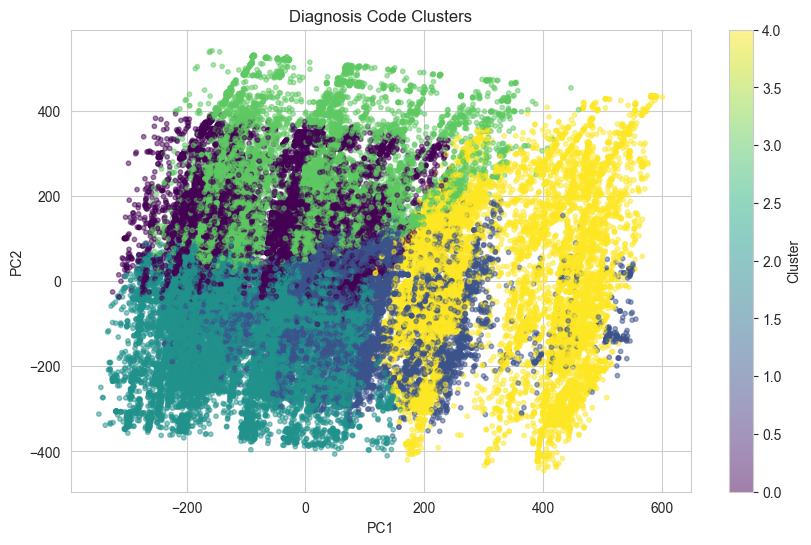

diag_cluster
2    43262
0    20060
4    13521
1    13100
3    11823
Name: count, dtype: int64


In [62]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/diabetic_data.csv")

# Handle missing values
df['diag_1'] = df['diag_1'].replace('?', 'Unknown')
df['diag_2'] = df['diag_2'].replace('?', 'Unknown')
df['diag_3'] = df['diag_3'].replace('?', 'Unknown')

# Encode diagnosis codes
le = LabelEncoder()
diag_encoded = pd.DataFrame({
    'diag_1': le.fit_transform(df['diag_1'].astype(str)),
    'diag_2': le.fit_transform(df['diag_2'].astype(str)),
    'diag_3': le.fit_transform(df['diag_3'].astype(str))
})

# Apply K-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(diag_encoded)

# Visualize with PCA
pca = PCA(n_components=2)
diag_pca = pca.fit_transform(diag_encoded)

plt.figure(figsize=(10, 6))
plt.scatter(diag_pca[:, 0], diag_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5, s=10)
plt.colorbar(label='Cluster')
plt.title('Diagnosis Code Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Add to dataframe
df['diag_cluster'] = clusters
print(df['diag_cluster'].value_counts())

LOADING DATA
Dataset shape: (101766, 50)

Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

First few rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Cauca

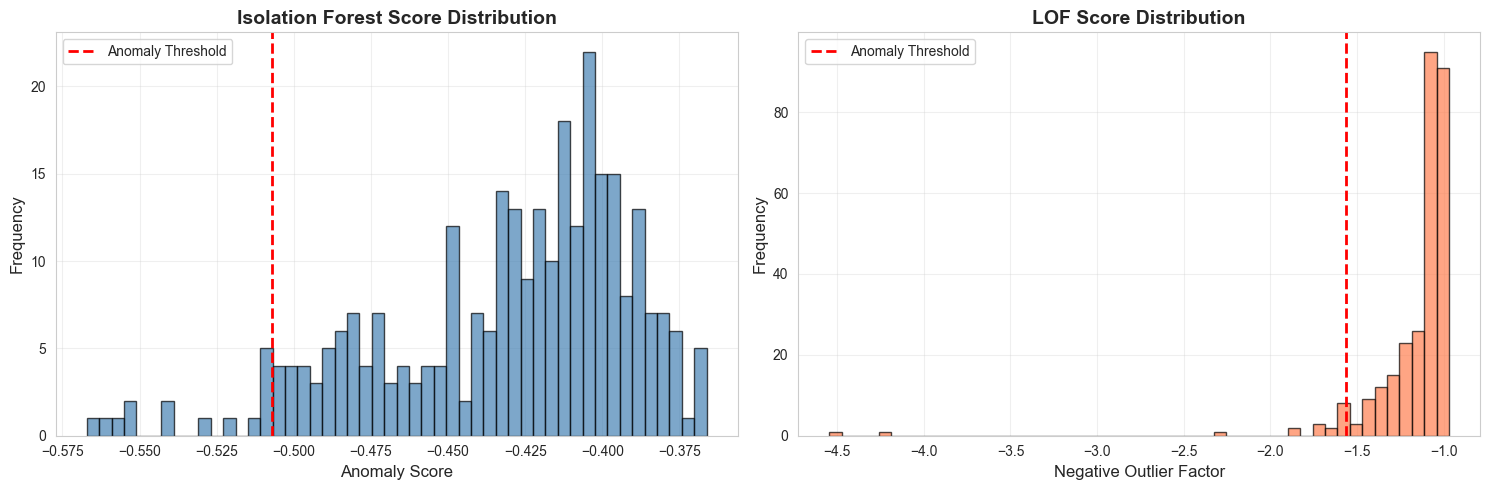


Creating PCA visualization...


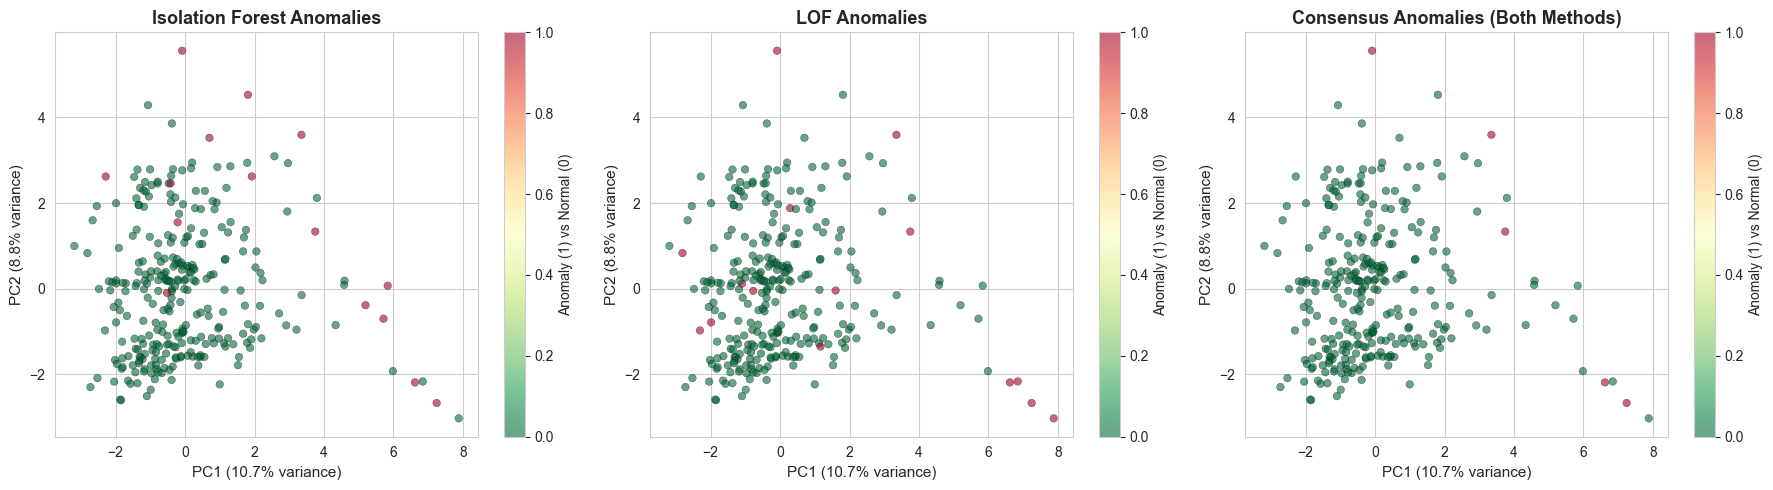

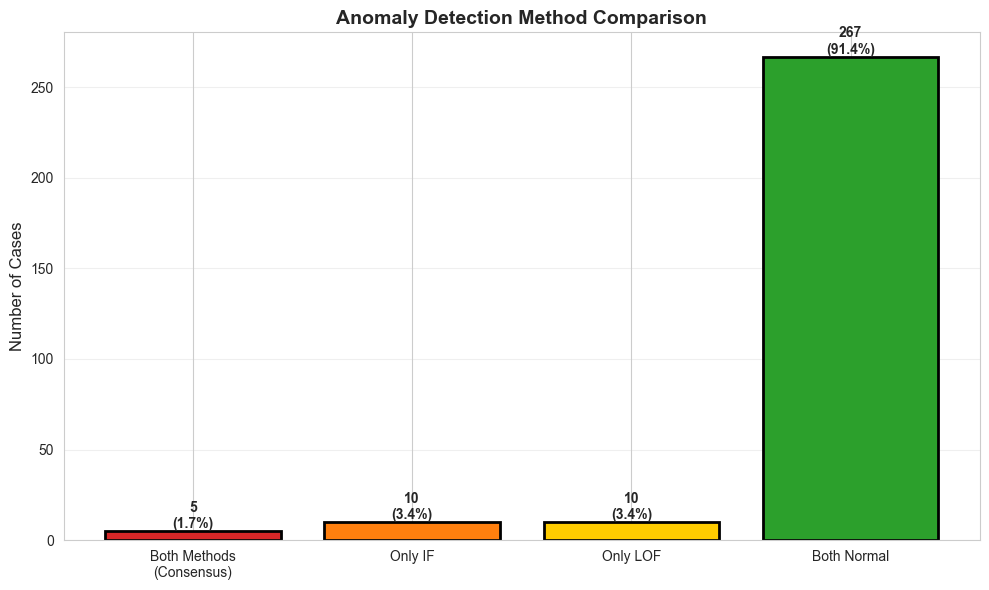


ANALYZING TOP ANOMALIES

🔴 Top 10 Most Anomalous Cases (Isolation Forest):
        time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
79573                  9                  98               5               24   
100386                 6                  51               0               20   
77057                 14                  88               2               34   
70552                  9                  91               6               28   
32699                 10                  58               0               19   
12837                  1                  47               0                9   
66117                  5                  83               0               19   
85152                  9                  68               2               17   
79525                  2                  63               0               12   
11978                 13                  75               0               16   

        number_outpatient  numbe

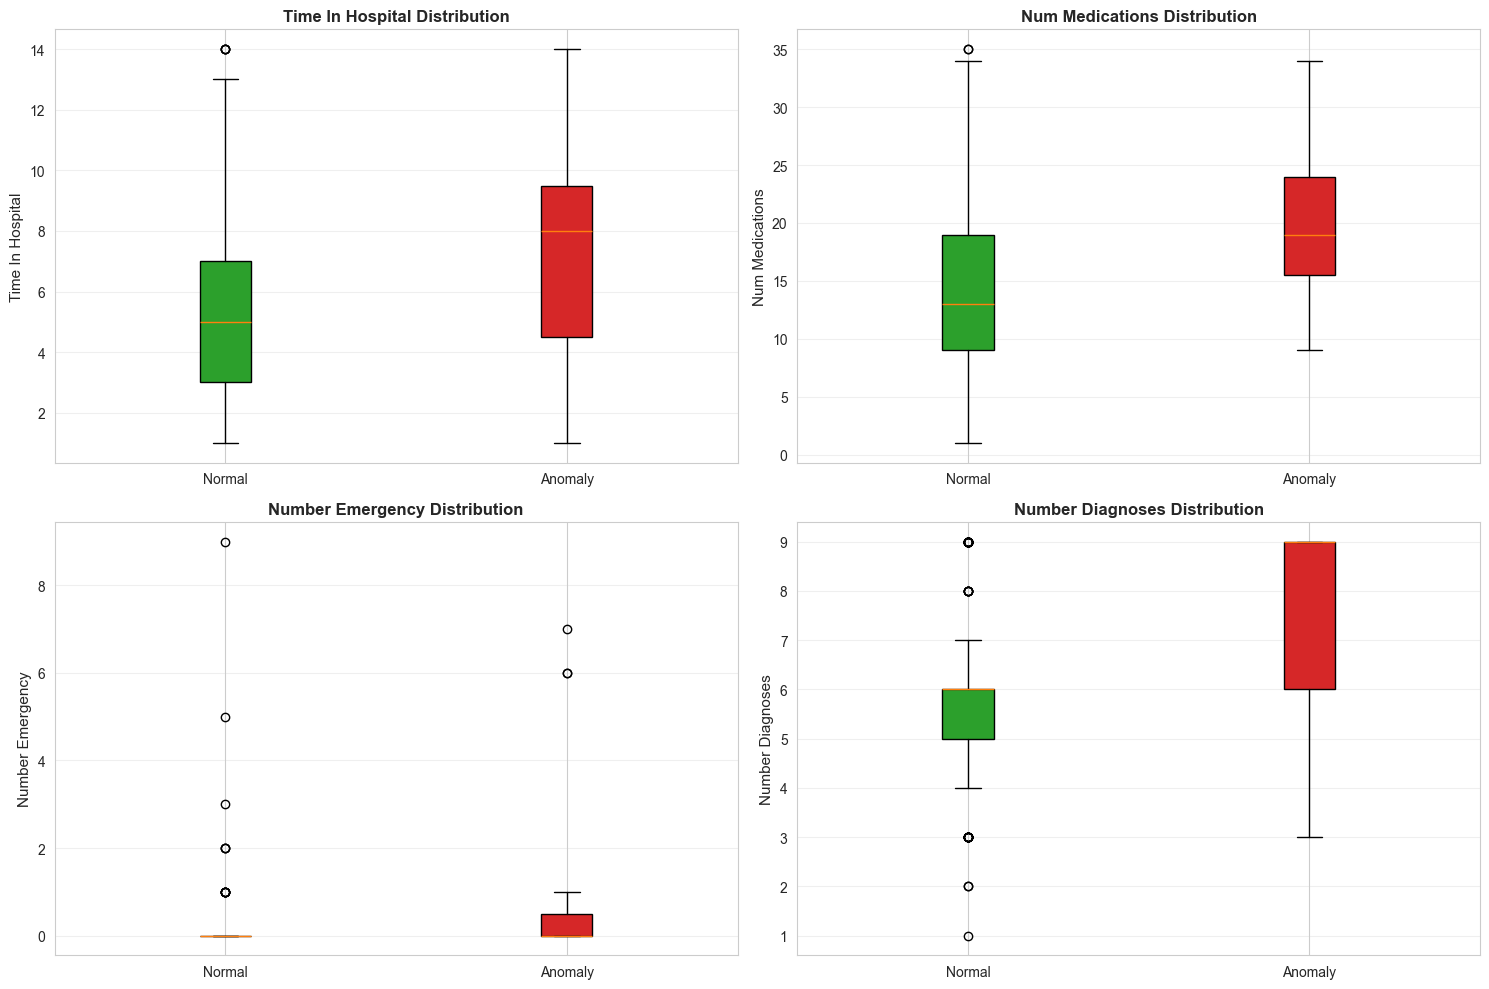


READMISSION ANALYSIS FOR ANOMALIES

Readmission counts (Normal patients):
readmitted
>30    129
NO     114
<30     34
Name: count, dtype: int64

Readmission counts (Anomalous patients):
readmitted
>30    10
NO      4
<30     1
Name: count, dtype: int64


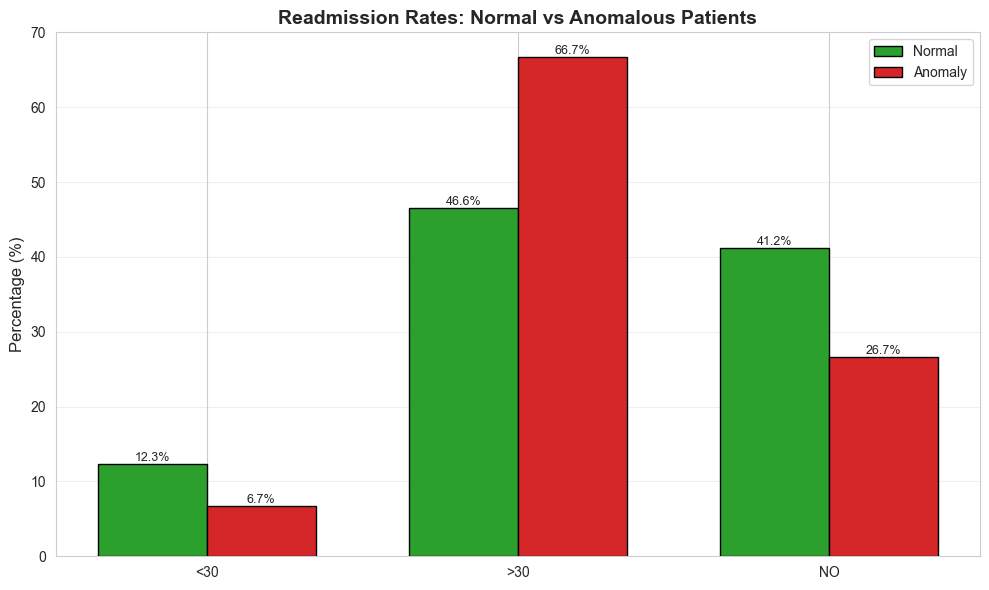


SAVING RESULTS
✅ Saved: results/tables/anomaly_detection_summary.csv

✨ ANOMALY DETECTION COMPLETE!

📊 Key Findings:
  - Isolation Forest: 15 anomalies (5.14%)
  - LOF: 15 anomalies (5.14%)
  - Consensus: 5 anomalies (1.71%)
  - Agreement rate: 93.15%

🎯 Next Steps:
  1. Investigate consensus anomalies for data quality issues
  2. Review high-risk cases with clinical experts
  3. Consider ensemble anomaly detection for better accuracy
  4. Integrate with clustering results for patient segmentation


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# =========================
# 1. LOAD DATA
# =========================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv("data/diabetic_data.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")

# =========================
# 2. FEATURE SELECTION FOR ANOMALY DETECTION
# =========================
print("\n" + "="*60)
print("FEATURE SELECTION FOR ANOMALY DETECTION")
print("="*60)

# Select features that indicate unusual patient encounters
# Focus on: utilization, procedures, medications, and outcomes

numeric_features = [
    # Hospital utilization (KEY indicators)
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

categorical_features = [
    "race",
    "gender",
    "age",  # age is categorical in this dataset (e.g., "[50-60)")
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "change",  # medication change
    "diabetesMed"  # diabetes medication prescribed
]

# Optional: Include medication features (many binary indicators)
medication_features = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "glipizide", "glyburide", "pioglitazone",
    "rosiglitazone", "insulin"
]

# Combine all features
all_features = numeric_features + categorical_features + medication_features

print(f"\nSelected features for anomaly detection:")
print(f"  - Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"  - Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"  - Medication features ({len(medication_features)}): {medication_features}")
print(f"  - Total: {len(all_features)} features")

# Create working dataframe
df_anomaly = df[all_features + ['readmitted', 'encounter_id', 'patient_nbr']].copy()

# =========================
# 3. DATA PREPROCESSING
# =========================
print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

# Check for missing values represented as "?"
missing_check = df_anomaly.apply(lambda x: (x == "?").sum())
print(f"\nMissing values (represented as '?'):")
print(missing_check[missing_check > 0])

# Replace ? with NaN
df_anomaly = df_anomaly.replace("?", np.nan)

# Check data types
print(f"\nData types before conversion:")
print(df_anomaly.dtypes.value_counts())

# Drop rows with missing values in key features
initial_rows = len(df_anomaly)
df_anomaly = df_anomaly.dropna(subset=numeric_features + categorical_features)
print(f"\nDropped {initial_rows - len(df_anomaly)} rows with missing values")
print(f"Final dataset size: {df_anomaly.shape}")

# Separate features for encoding
X_numeric = df_anomaly[numeric_features].copy()
X_categorical = df_anomaly[categorical_features].copy()
X_medications = df_anomaly[medication_features].copy()

print(f"\nNumeric features shape: {X_numeric.shape}")
print(f"Categorical features shape: {X_categorical.shape}")
print(f"Medication features shape: {X_medications.shape}")

# =========================
# 4. ENCODE CATEGORICAL FEATURES
# =========================
print("\n" + "="*60)
print("ENCODING CATEGORICAL FEATURES")
print("="*60)

# Label encode categorical features (simpler for anomaly detection)
X_categorical_encoded = X_categorical.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} unique values")

# Encode medication features (No/Yes/Steady/Up/Down -> numeric)
X_medications_encoded = X_medications.copy()
for col in medication_features:
    le = LabelEncoder()
    X_medications_encoded[col] = le.fit_transform(X_medications[col].astype(str))
    label_encoders[col] = le

# Combine all encoded features
X_combined = pd.concat([X_numeric, X_categorical_encoded, X_medications_encoded], axis=1)
print(f"\nCombined feature matrix shape: {X_combined.shape}")

# =========================
# 5. SCALE FEATURES
# =========================
print("\n" + "="*60)
print("SCALING FEATURES")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

# =========================
# 6. ISOLATION FOREST
# =========================
print("\n" + "="*60)
print("ISOLATION FOREST ANOMALY DETECTION")
print("="*60)

# Test different contamination rates
contamination_rates = [0.01, 0.05, 0.10]
if_results = {}

for contamination in contamination_rates:
    print(f"\n--- Testing contamination={contamination} ---")
    
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100,
        max_samples='auto',
        n_jobs=-1
    )
    
    predictions = iso_forest.fit_predict(X_scaled)
    scores = iso_forest.score_samples(X_scaled)
    
    if_results[contamination] = {
        'model': iso_forest,
        'predictions': predictions,
        'scores': scores,
        'n_anomalies': np.sum(predictions == -1),
        'pct_anomalies': np.sum(predictions == -1) / len(predictions) * 100
    }
    
    print(f"Anomalies detected: {if_results[contamination]['n_anomalies']} "
          f"({if_results[contamination]['pct_anomalies']:.2f}%)")
    print(f"Score range: [{scores.min():.3f}, {scores.max():.3f}]")

# Use optimal contamination
optimal_contamination = 0.05
iso_forest = if_results[optimal_contamination]['model']
if_predictions = if_results[optimal_contamination]['predictions']
if_scores = if_results[optimal_contamination]['scores']

print(f"\n✅ Using contamination={optimal_contamination}")
print(f"Total anomalies (Isolation Forest): {np.sum(if_predictions == -1)}")

# =========================
# 7. LOCAL OUTLIER FACTOR (LOF)
# =========================
print("\n" + "="*60)
print("LOCAL OUTLIER FACTOR (LOF) ANOMALY DETECTION")
print("="*60)

# Test different n_neighbors
n_neighbors_values = [10, 20, 30]
lof_results = {}

for n_neighbors in n_neighbors_values:
    print(f"\n--- Testing n_neighbors={n_neighbors} ---")
    
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=optimal_contamination,
        novelty=False,
        n_jobs=-1
    )
    
    predictions = lof.fit_predict(X_scaled)
    scores = lof.negative_outlier_factor_
    
    lof_results[n_neighbors] = {
        'model': lof,
        'predictions': predictions,
        'scores': scores,
        'n_anomalies': np.sum(predictions == -1),
        'pct_anomalies': np.sum(predictions == -1) / len(predictions) * 100
    }
    
    print(f"Anomalies detected: {lof_results[n_neighbors]['n_anomalies']} "
          f"({lof_results[n_neighbors]['pct_anomalies']:.2f}%)")
    print(f"Score range: [{scores.min():.3f}, {scores.max():.3f}]")

# Use optimal n_neighbors
optimal_neighbors = 20
lof = lof_results[optimal_neighbors]['model']
lof_predictions = lof_results[optimal_neighbors]['predictions']
lof_scores = lof_results[optimal_neighbors]['scores']

print(f"\n✅ Using n_neighbors={optimal_neighbors}")
print(f"Total anomalies (LOF): {np.sum(lof_predictions == -1)}")

# =========================
# 8. ADD RESULTS TO DATAFRAME
# =========================
print("\n" + "="*60)
print("ADDING ANOMALY FLAGS TO DATASET")
print("="*60)

df_anomaly['if_prediction'] = if_predictions
df_anomaly['if_score'] = if_scores
df_anomaly['if_anomaly'] = (if_predictions == -1).astype(int)

df_anomaly['lof_prediction'] = lof_predictions
df_anomaly['lof_score'] = lof_scores
df_anomaly['lof_anomaly'] = (lof_predictions == -1).astype(int)

# Create consensus column
both_anomaly = (df_anomaly['if_anomaly'] == 1) & (df_anomaly['lof_anomaly'] == 1)
df_anomaly['consensus_anomaly'] = both_anomaly.astype(int)

print(f"✅ Added anomaly flags to dataset")

# =========================
# 9. COMPARISON OF METHODS
# =========================
print("\n" + "="*60)
print("COMPARING ISOLATION FOREST vs LOF")
print("="*60)

only_if = (df_anomaly['if_anomaly'] == 1) & (df_anomaly['lof_anomaly'] == 0)
only_lof = (df_anomaly['if_anomaly'] == 0) & (df_anomaly['lof_anomaly'] == 1)
both_normal = (df_anomaly['if_anomaly'] == 0) & (df_anomaly['lof_anomaly'] == 0)

print(f"Both methods agree (Anomaly): {both_anomaly.sum()}")
print(f"Both methods agree (Normal): {both_normal.sum()}")
print(f"Only Isolation Forest: {only_if.sum()}")
print(f"Only LOF: {only_lof.sum()}")
print(f"\nAgreement rate: {(both_anomaly.sum() + both_normal.sum()) / len(df_anomaly) * 100:.2f}%")
print(f"High-confidence anomalies (consensus): {both_anomaly.sum()}")

# Comparison matrix
comparison_matrix = pd.DataFrame({
    'LOF Normal': [both_normal.sum(), only_if.sum()],
    'LOF Anomaly': [only_lof.sum(), both_anomaly.sum()]
}, index=['IF Normal', 'IF Anomaly'])

print("\nComparison Matrix:")
print(comparison_matrix)

# =========================
# 10. VISUALIZATIONS
# =========================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 10.1 Score distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(if_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=if_scores[if_predictions == -1].max(), 
                color='red', linestyle='--', linewidth=2, 
                label=f'Anomaly Threshold')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Isolation Forest Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(lof_scores, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(x=lof_scores[lof_predictions == -1].max(), 
                color='red', linestyle='--', linewidth=2,
                label='Anomaly Threshold')
axes[1].set_xlabel('Negative Outlier Factor', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('LOF Score Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('results/figures/anomaly_detection/score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# 10.2 PCA Visualization
print("\nCreating PCA visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Isolation Forest
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=df_anomaly['if_anomaly'], 
                           cmap='RdYlGn_r', 
                           alpha=0.6, 
                           s=30,
                           edgecolors='black',
                           linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title('Isolation Forest Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Anomaly (1) vs Normal (0)')

# LOF
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=df_anomaly['lof_anomaly'], 
                           cmap='RdYlGn_r', 
                           alpha=0.6, 
                           s=30,
                           edgecolors='black',
                           linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[1].set_title('LOF Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Anomaly (1) vs Normal (0)')

# Consensus
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=df_anomaly['consensus_anomaly'], 
                           cmap='RdYlGn_r', 
                           alpha=0.6, 
                           s=30,
                           edgecolors='black',
                           linewidth=0.3)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[2].set_title('Consensus Anomalies (Both Methods)', fontsize=13, fontweight='bold')
plt.colorbar(scatter3, ax=axes[2], label='Anomaly (1) vs Normal (0)')

plt.tight_layout()
#plt.savefig('results/figures/anomaly_detection/pca_anomalies.png', dpi=300, bbox_inches='tight')
plt.show()

# 10.3 Method comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Both Methods\n(Consensus)', 'Only IF', 'Only LOF', 'Both Normal']
counts = [both_anomaly.sum(), only_if.sum(), only_lof.sum(), both_normal.sum()]
colors = ['#d62728', '#ff7f0e', '#ffcc00', '#2ca02c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.set_title('Anomaly Detection Method Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df_anomaly)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
#plt.savefig('results/figures/anomaly_detection/method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =========================
# 11. ANALYZE TOP ANOMALIES
# =========================
print("\n" + "="*60)
print("ANALYZING TOP ANOMALIES")
print("="*60)

# Get most anomalous cases
display_cols = numeric_features + ['readmitted', 'if_score', 'lof_score']

# Top 10 by Isolation Forest
top_if = df_anomaly[df_anomaly['if_anomaly'] == 1].nsmallest(10, 'if_score')
print("\n🔴 Top 10 Most Anomalous Cases (Isolation Forest):")
print(top_if[display_cols])

# Top 10 by LOF
top_lof = df_anomaly[df_anomaly['lof_anomaly'] == 1].nsmallest(10, 'lof_score')
print("\n🔴 Top 10 Most Anomalous Cases (LOF):")
print(top_lof[display_cols])

# Consensus anomalies
consensus_cases = df_anomaly[df_anomaly['consensus_anomaly'] == 1]
print(f"\n🔴 High-Confidence Anomalies (Consensus): {len(consensus_cases)}")
if len(consensus_cases) > 0:
    print(consensus_cases[display_cols].head(10))

# =========================
# 12. FEATURE ANALYSIS
# =========================
print("\n" + "="*60)
print("FEATURE ANALYSIS: ANOMALIES vs NORMAL")
print("="*60)

# Compare numeric features
feature_comparison = pd.DataFrame({
    'Feature': numeric_features,
    'Normal_Mean': [df_anomaly[df_anomaly['if_anomaly'] == 0][f].mean() for f in numeric_features],
    'Anomaly_Mean': [df_anomaly[df_anomaly['if_anomaly'] == 1][f].mean() for f in numeric_features],
})

feature_comparison['Difference'] = feature_comparison['Anomaly_Mean'] - feature_comparison['Normal_Mean']
feature_comparison['Pct_Difference'] = (feature_comparison['Difference'] / feature_comparison['Normal_Mean'] * 100).round(2)

print("\nNumeric Feature Comparison:")
print(feature_comparison.sort_values('Pct_Difference', key=abs, ascending=False))

# Visualize key differences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

key_features = ['time_in_hospital', 'num_medications', 'number_emergency', 'number_diagnoses']

for idx, feature in enumerate(key_features):
    data_to_plot = [
        df_anomaly[df_anomaly['if_anomaly'] == 0][feature],
        df_anomaly[df_anomaly['if_anomaly'] == 1][feature]
    ]
    
    bp = axes[idx].boxplot(data_to_plot, labels=['Normal', 'Anomaly'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#2ca02c')
    bp['boxes'][1].set_facecolor('#d62728')
    
    axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
#plt.savefig('results/figures/anomaly_detection/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# =========================
# 13. READMISSION ANALYSIS
# =========================
print("\n" + "="*60)
print("READMISSION ANALYSIS FOR ANOMALIES")
print("="*60)

readmit_normal = df_anomaly[df_anomaly['if_anomaly'] == 0]['readmitted'].value_counts()
readmit_anomaly = df_anomaly[df_anomaly['if_anomaly'] == 1]['readmitted'].value_counts()

print("\nReadmission counts (Normal patients):")
print(readmit_normal)
print("\nReadmission counts (Anomalous patients):")
print(readmit_anomaly)

# Calculate readmission rates
readmit_categories = ['<30', '>30', 'NO']
normal_rates = [readmit_normal.get(cat, 0) / len(df_anomaly[df_anomaly['if_anomaly'] == 0]) * 100 
                for cat in readmit_categories]
anomaly_rates = [readmit_anomaly.get(cat, 0) / len(df_anomaly[df_anomaly['if_anomaly'] == 1]) * 100 
                 for cat in readmit_categories]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(readmit_categories))
width = 0.35

bars1 = ax.bar(x - width/2, normal_rates, width, label='Normal', color='#2ca02c', edgecolor='black')
bars2 = ax.bar(x + width/2, anomaly_rates, width, label='Anomaly', color='#d62728', edgecolor='black')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Readmission Rates: Normal vs Anomalous Patients', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(readmit_categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
#plt.savefig('results/figures/anomaly_detection/readmission_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =========================
# 14. SAVE RESULTS
# =========================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save full dataset with anomaly flags
#df_anomaly.to_csv('data/processed/anomaly_flagged_patients.csv', index=False)
#print("✅ Saved: data/processed/anomaly_flagged_patients.csv")

# Save consensus anomalies only
#if len(consensus_cases) > 0:
#    consensus_cases.to_csv('results/tables/consensus_anomalies.csv', index=False)
#    print("✅ Saved: results/tables/consensus_anomalies.csv")

# Save feature comparison
#feature_comparison.to_csv('results/tables/anomaly_feature_analysis.csv', index=False)
#print("✅ Saved: results/tables/anomaly_feature_analysis.csv")

# Save summary statistics
summary = pd.DataFrame({
    'Method': ['Isolation Forest', 'LOF', 'Consensus'],
    'N_Anomalies': [
        df_anomaly['if_anomaly'].sum(),
        df_anomaly['lof_anomaly'].sum(),
        df_anomaly['consensus_anomaly'].sum()
    ],
    'Percentage': [
        df_anomaly['if_anomaly'].mean() * 100,
        df_anomaly['lof_anomaly'].mean() * 100,
        df_anomaly['consensus_anomaly'].mean() * 100
    ]
})
#summary.to_csv('results/tables/anomaly_detection_summary.csv', index=False)
print("✅ Saved: results/tables/anomaly_detection_summary.csv")

print("\n" + "="*60)
print("✨ ANOMALY DETECTION COMPLETE!")
print("="*60)
print(f"\n📊 Key Findings:")
print(f"  - Isolation Forest: {df_anomaly['if_anomaly'].sum():,} anomalies ({df_anomaly['if_anomaly'].mean()*100:.2f}%)")
print(f"  - LOF: {df_anomaly['lof_anomaly'].sum():,} anomalies ({df_anomaly['lof_anomaly'].mean()*100:.2f}%)")
print(f"  - Consensus: {df_anomaly['consensus_anomaly'].sum():,} anomalies ({df_anomaly['consensus_anomaly'].mean()*100:.2f}%)")
print(f"  - Agreement rate: {(both_anomaly.sum() + both_normal.sum()) / len(df_anomaly) * 100:.2f}%")
print(f"\n🎯 Next Steps:")
print(f"  1. Investigate consensus anomalies for data quality issues")
print(f"  2. Review high-risk cases with clinical experts")
print(f"  3. Consider ensemble anomaly detection for better accuracy")
print(f"  4. Integrate with clustering results for patient segmentation")

LOADING DATA
Dataset shape: (101766, 50)

FEATURE SELECTION FOR ANOMALY DETECTION
Total features: 28

PREPROCESSING
Dropped 101474 rows
Final size: (292, 31)

ENCODING CATEGORICAL FEATURES

SCALING FEATURES
Scaled data shape: (292, 28)

ISOLATION FOREST ANOMALY DETECTION

--- Testing contamination=0.01 ---
Anomalies: 3 (1.03%)

--- Testing contamination=0.05 ---
Anomalies: 15 (5.14%)

--- Testing contamination=0.1 ---
Anomalies: 30 (10.27%)

✅ Using contamination=0.05

DBSCAN ANOMALY DETECTION

--- Testing eps=0.5 ---
Anomalies (noise): 292 (100.00%)
Clusters found: 0

--- Testing eps=1.0 ---
Anomalies (noise): 292 (100.00%)
Clusters found: 0

--- Testing eps=1.5 ---
Anomalies (noise): 292 (100.00%)
Clusters found: 0

--- Testing eps=2.0 ---
Anomalies (noise): 292 (100.00%)
Clusters found: 0

✅ Using eps=1.5
Total anomalies (DBSCAN): 292

ADDING ANOMALY FLAGS

COMPARING ISOLATION FOREST vs DBSCAN
Both methods agree (Anomaly): 15
Both methods agree (Normal): 0
Only Isolation Forest: 0
O

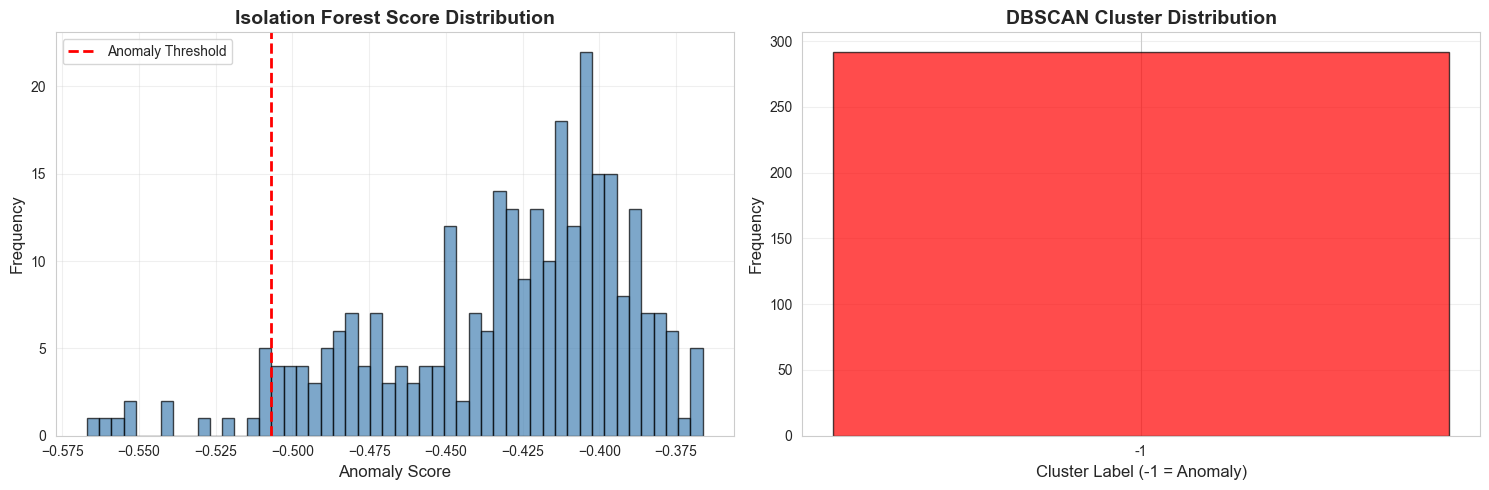


Creating PCA visualization...


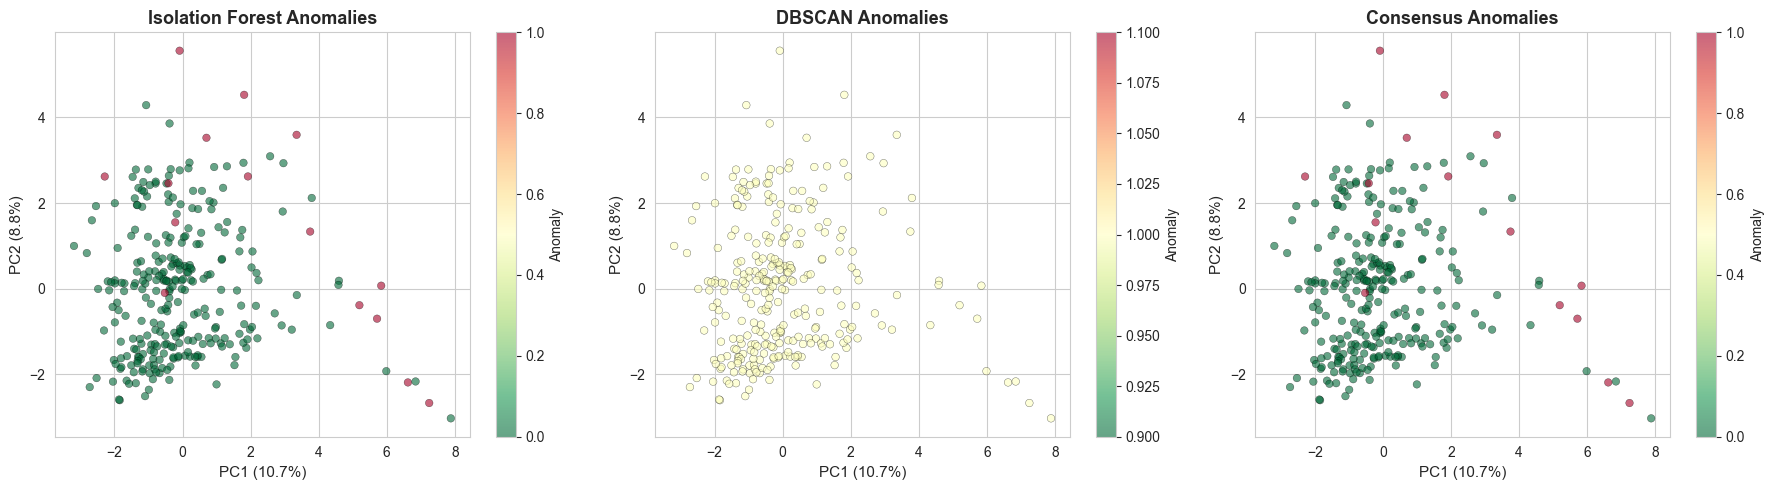

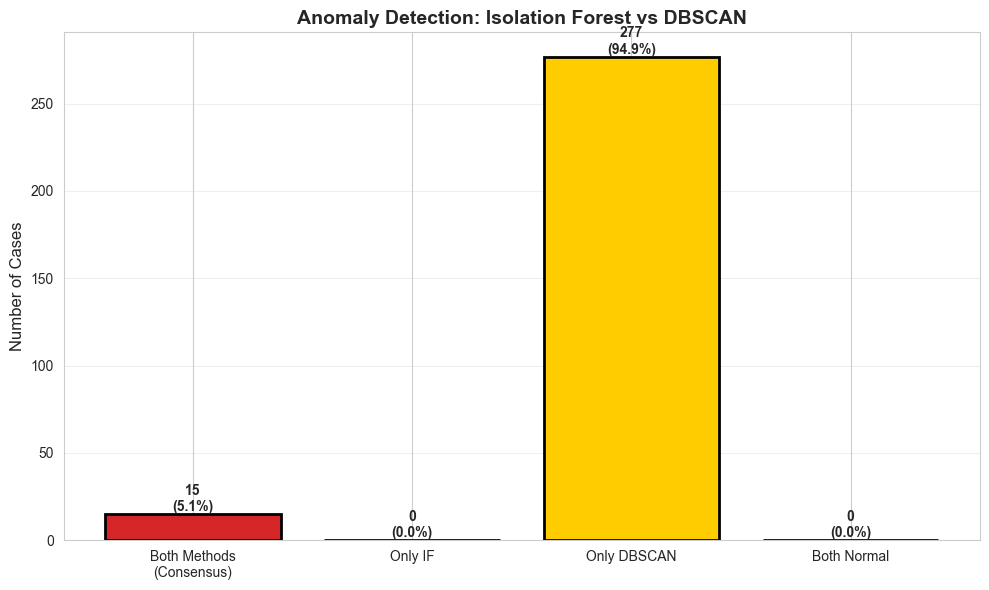


✨ ANOMALY DETECTION COMPLETE!

📊 Key Findings:
  - Isolation Forest: 15 anomalies (5.14%)
  - DBSCAN: 292 anomalies (100.00%)
  - Consensus: 15 anomalies (5.14%)
  - Agreement rate: 5.14%
  - DBSCAN found 0 clusters


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# =========================
# 1. LOAD DATA
# =========================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv("data/diabetic_data.csv")
print(f"Dataset shape: {df.shape}")

# =========================
# 2. FEATURE SELECTION
# =========================
print("\n" + "="*60)
print("FEATURE SELECTION FOR ANOMALY DETECTION")
print("="*60)

numeric_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

categorical_features = [
    "race", "gender", "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "change",
    "diabetesMed"
]

medication_features = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "glipizide", "glyburide", "pioglitazone",
    "rosiglitazone", "insulin"
]

all_features = numeric_features + categorical_features + medication_features

print(f"Total features: {len(all_features)}")

df_anomaly = df[all_features + ['readmitted', 'encounter_id', 'patient_nbr']].copy()

# =========================
# 3. PREPROCESSING
# =========================
print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

df_anomaly = df_anomaly.replace("?", np.nan)
initial_rows = len(df_anomaly)
df_anomaly = df_anomaly.dropna(subset=numeric_features + categorical_features)
print(f"Dropped {initial_rows - len(df_anomaly)} rows")
print(f"Final size: {df_anomaly.shape}")

# =========================
# 4. ENCODING
# =========================
print("\n" + "="*60)
print("ENCODING CATEGORICAL FEATURES")
print("="*60)

X_numeric = df_anomaly[numeric_features].copy()
X_categorical = df_anomaly[categorical_features].copy()
X_medications = df_anomaly[medication_features].copy()

X_categorical_encoded = X_categorical.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col].astype(str))
    label_encoders[col] = le

X_medications_encoded = X_medications.copy()
for col in medication_features:
    le = LabelEncoder()
    X_medications_encoded[col] = le.fit_transform(X_medications[col].astype(str))
    label_encoders[col] = le

X_combined = pd.concat([X_numeric, X_categorical_encoded, X_medications_encoded], axis=1)

# =========================
# 5. SCALING
# =========================
print("\n" + "="*60)
print("SCALING FEATURES")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
print(f"Scaled data shape: {X_scaled.shape}")

# =========================
# 6. ISOLATION FOREST
# =========================
print("\n" + "="*60)
print("ISOLATION FOREST ANOMALY DETECTION")
print("="*60)

contamination_rates = [0.01, 0.05, 0.10]
if_results = {}

for contamination in contamination_rates:
    print(f"\n--- Testing contamination={contamination} ---")
    
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100,
        max_samples='auto',
        n_jobs=-1
    )
    
    predictions = iso_forest.fit_predict(X_scaled)
    scores = iso_forest.score_samples(X_scaled)
    
    if_results[contamination] = {
        'model': iso_forest,
        'predictions': predictions,
        'scores': scores,
        'n_anomalies': np.sum(predictions == -1),
        'pct_anomalies': np.sum(predictions == -1) / len(predictions) * 100
    }
    
    print(f"Anomalies: {if_results[contamination]['n_anomalies']} ({if_results[contamination]['pct_anomalies']:.2f}%)")

optimal_contamination = 0.05
iso_forest = if_results[optimal_contamination]['model']
if_predictions = if_results[optimal_contamination]['predictions']
if_scores = if_results[optimal_contamination]['scores']

print(f"\n✅ Using contamination={optimal_contamination}")

# =========================
# 7. DBSCAN
# =========================
print("\n" + "="*60)
print("DBSCAN ANOMALY DETECTION")
print("="*60)

# Test different eps values
eps_values = [0.5, 1.0, 1.5, 2.0]
dbscan_results = {}

for eps in eps_values:
    print(f"\n--- Testing eps={eps} ---")
    
    dbscan = DBSCAN(
        eps=eps,
        min_samples=5,
        n_jobs=-1
    )
    
    predictions = dbscan.fit_predict(X_scaled)
    
    # In DBSCAN, -1 = noise/outlier, others are cluster labels
    n_anomalies = np.sum(predictions == -1)
    n_clusters = len(set(predictions)) - (1 if -1 in predictions else 0)
    
    dbscan_results[eps] = {
        'model': dbscan,
        'predictions': predictions,
        'n_anomalies': n_anomalies,
        'pct_anomalies': n_anomalies / len(predictions) * 100,
        'n_clusters': n_clusters
    }
    
    print(f"Anomalies (noise): {n_anomalies} ({n_anomalies/len(predictions)*100:.2f}%)")
    print(f"Clusters found: {n_clusters}")

# Choose eps that gives similar anomaly rate to IF
optimal_eps = 1.5
dbscan = dbscan_results[optimal_eps]['model']
dbscan_predictions = dbscan_results[optimal_eps]['predictions']

print(f"\n✅ Using eps={optimal_eps}")
print(f"Total anomalies (DBSCAN): {dbscan_results[optimal_eps]['n_anomalies']}")

# =========================
# 8. ADD RESULTS TO DATAFRAME
# =========================
print("\n" + "="*60)
print("ADDING ANOMALY FLAGS")
print("="*60)

df_anomaly['if_prediction'] = if_predictions
df_anomaly['if_score'] = if_scores
df_anomaly['if_anomaly'] = (if_predictions == -1).astype(int)

df_anomaly['dbscan_prediction'] = dbscan_predictions
df_anomaly['dbscan_anomaly'] = (dbscan_predictions == -1).astype(int)

# Consensus: both methods agree on anomaly
both_anomaly = (df_anomaly['if_anomaly'] == 1) & (df_anomaly['dbscan_anomaly'] == 1)
df_anomaly['consensus_anomaly'] = both_anomaly.astype(int)

# =========================
# 9. COMPARISON
# =========================
print("\n" + "="*60)
print("COMPARING ISOLATION FOREST vs DBSCAN")
print("="*60)

only_if = (df_anomaly['if_anomaly'] == 1) & (df_anomaly['dbscan_anomaly'] == 0)
only_dbscan = (df_anomaly['if_anomaly'] == 0) & (df_anomaly['dbscan_anomaly'] == 1)
both_normal = (df_anomaly['if_anomaly'] == 0) & (df_anomaly['dbscan_anomaly'] == 0)

print(f"Both methods agree (Anomaly): {both_anomaly.sum()}")
print(f"Both methods agree (Normal): {both_normal.sum()}")
print(f"Only Isolation Forest: {only_if.sum()}")
print(f"Only DBSCAN: {only_dbscan.sum()}")
print(f"\nAgreement rate: {(both_anomaly.sum() + both_normal.sum()) / len(df_anomaly) * 100:.2f}%")

comparison_matrix = pd.DataFrame({
    'DBSCAN Normal': [both_normal.sum(), only_if.sum()],
    'DBSCAN Anomaly': [only_dbscan.sum(), both_anomaly.sum()]
}, index=['IF Normal', 'IF Anomaly'])

print("\nComparison Matrix:")
print(comparison_matrix)

# =========================
# 10. VISUALIZATIONS
# =========================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Score distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(if_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=if_scores[if_predictions == -1].max(), 
                color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Isolation Forest Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DBSCAN cluster distribution
cluster_counts = pd.Series(dbscan_predictions).value_counts().sort_index()
axes[1].bar(range(len(cluster_counts)), cluster_counts.values, 
           color=['red' if idx == -1 else 'steelblue' for idx in cluster_counts.index],
           edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Cluster Label (-1 = Anomaly)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('DBSCAN Cluster Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(cluster_counts)))
axes[1].set_xticklabels(cluster_counts.index)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# PCA Visualization
print("\nCreating PCA visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Isolation Forest
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=df_anomaly['if_anomaly'], 
                           cmap='RdYlGn_r', alpha=0.6, s=30,
                           edgecolors='black', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('Isolation Forest Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Anomaly')

# DBSCAN
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=df_anomaly['dbscan_anomaly'], 
                           cmap='RdYlGn_r', alpha=0.6, s=30,
                           edgecolors='black', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1].set_title('DBSCAN Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Anomaly')

# Consensus
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=df_anomaly['consensus_anomaly'], 
                           cmap='RdYlGn_r', alpha=0.6, s=30,
                           edgecolors='black', linewidth=0.3)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[2].set_title('Consensus Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter3, ax=axes[2], label='Anomaly')

plt.tight_layout()
plt.show()

# Comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Both Methods\n(Consensus)', 'Only IF', 'Only DBSCAN', 'Both Normal']
counts = [both_anomaly.sum(), only_if.sum(), only_dbscan.sum(), both_normal.sum()]
colors = ['#d62728', '#ff7f0e', '#ffcc00', '#2ca02c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.set_title('Anomaly Detection: Isolation Forest vs DBSCAN', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df_anomaly)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# =========================
# 11. SUMMARY
# =========================
print("\n" + "="*60)
print("✨ ANOMALY DETECTION COMPLETE!")
print("="*60)
print(f"\n📊 Key Findings:")
print(f"  - Isolation Forest: {df_anomaly['if_anomaly'].sum():,} anomalies ({df_anomaly['if_anomaly'].mean()*100:.2f}%)")
print(f"  - DBSCAN: {df_anomaly['dbscan_anomaly'].sum():,} anomalies ({df_anomaly['dbscan_anomaly'].mean()*100:.2f}%)")
print(f"  - Consensus: {df_anomaly['consensus_anomaly'].sum():,} anomalies ({df_anomaly['consensus_anomaly'].mean()*100:.2f}%)")
print(f"  - Agreement rate: {(both_anomaly.sum() + both_normal.sum()) / len(df_anomaly) * 100:.2f}%")
print(f"  - DBSCAN found {dbscan_results[optimal_eps]['n_clusters']} clusters")

LOADING DATA
Dataset shape: (101766, 50)

FEATURE SELECTION FOR ANOMALY DETECTION
Total features: 28

PREPROCESSING
Dropped 101474 rows
Final size: (292, 31)

ENCODING CATEGORICAL FEATURES

SCALING FEATURES
Scaled data shape: (292, 28)

ISOLATION FOREST ANOMALY DETECTION

--- Testing contamination=0.01 ---
Anomalies: 3 (1.03%)

--- Testing contamination=0.05 ---
Anomalies: 15 (5.14%)

--- Testing contamination=0.1 ---
Anomalies: 30 (10.27%)

✅ Using contamination=0.05

KMEANS CLUSTERING FOR ANOMALY DETECTION

Finding optimal k...
k=3: Silhouette=0.061, Inertia=7164
k=4: Silhouette=0.077, Inertia=6822
k=5: Silhouette=0.072, Inertia=6517
k=6: Silhouette=0.086, Inertia=6288
k=7: Silhouette=0.095, Inertia=6016
k=8: Silhouette=0.057, Inertia=5867
k=9: Silhouette=0.076, Inertia=5626
k=10: Silhouette=0.064, Inertia=5403

✅ Optimal k (by silhouette): 7
Clusters found: 7
Cluster distribution:
0     21
1     28
2     79
3      6
4     38
5    113
6      7
Name: count, dtype: int64

IDENTIFYING A

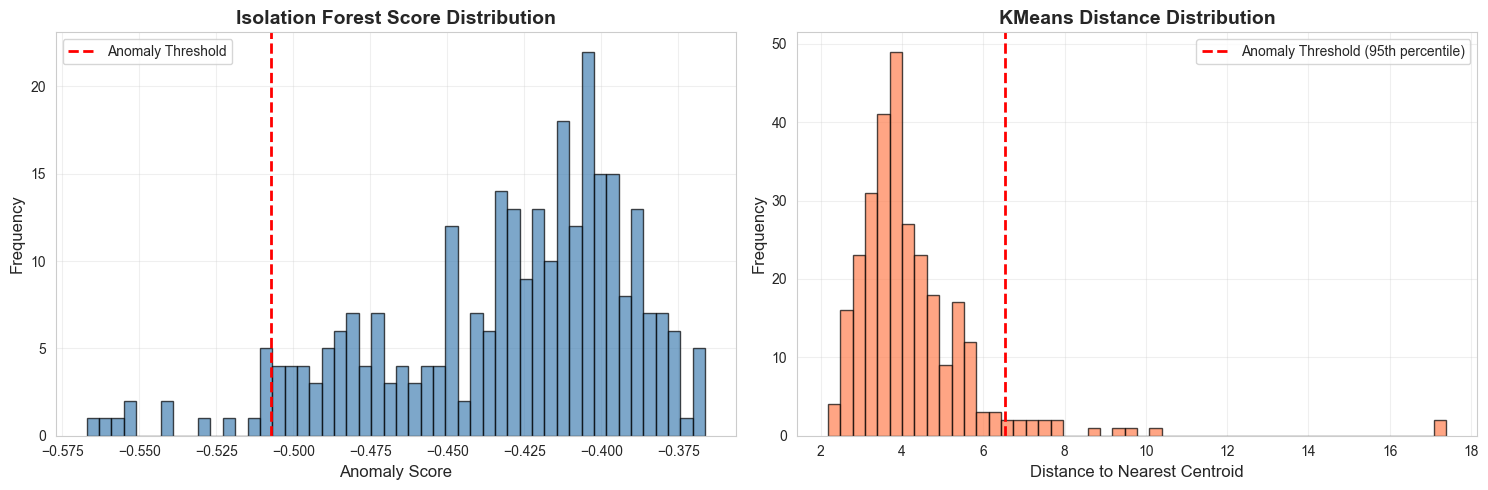

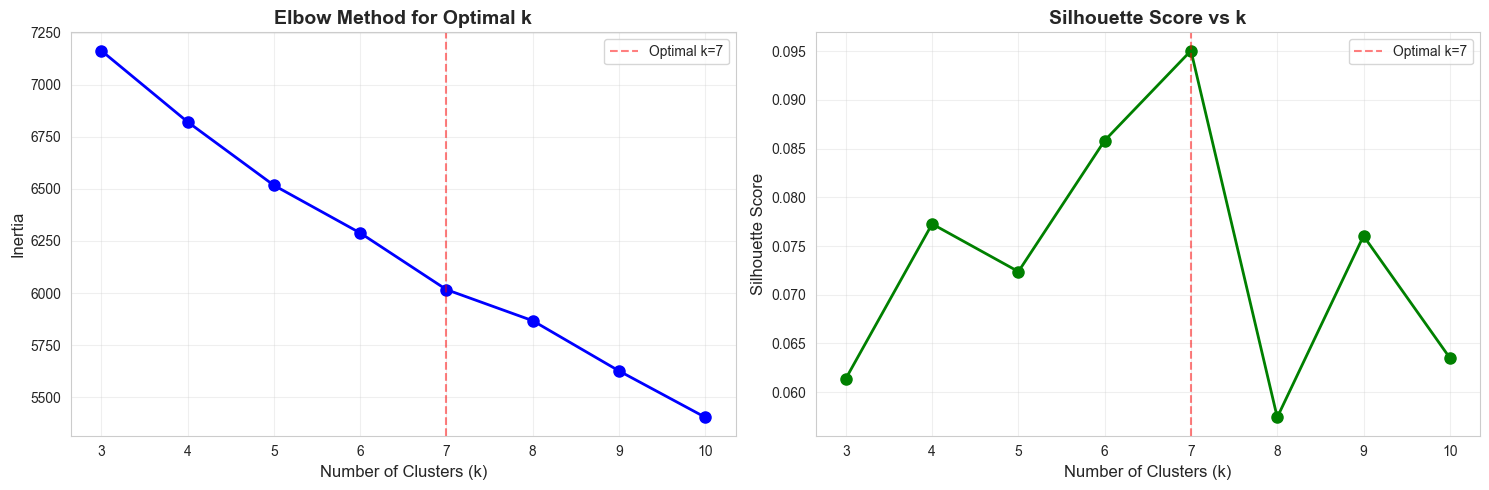


Creating PCA visualization...


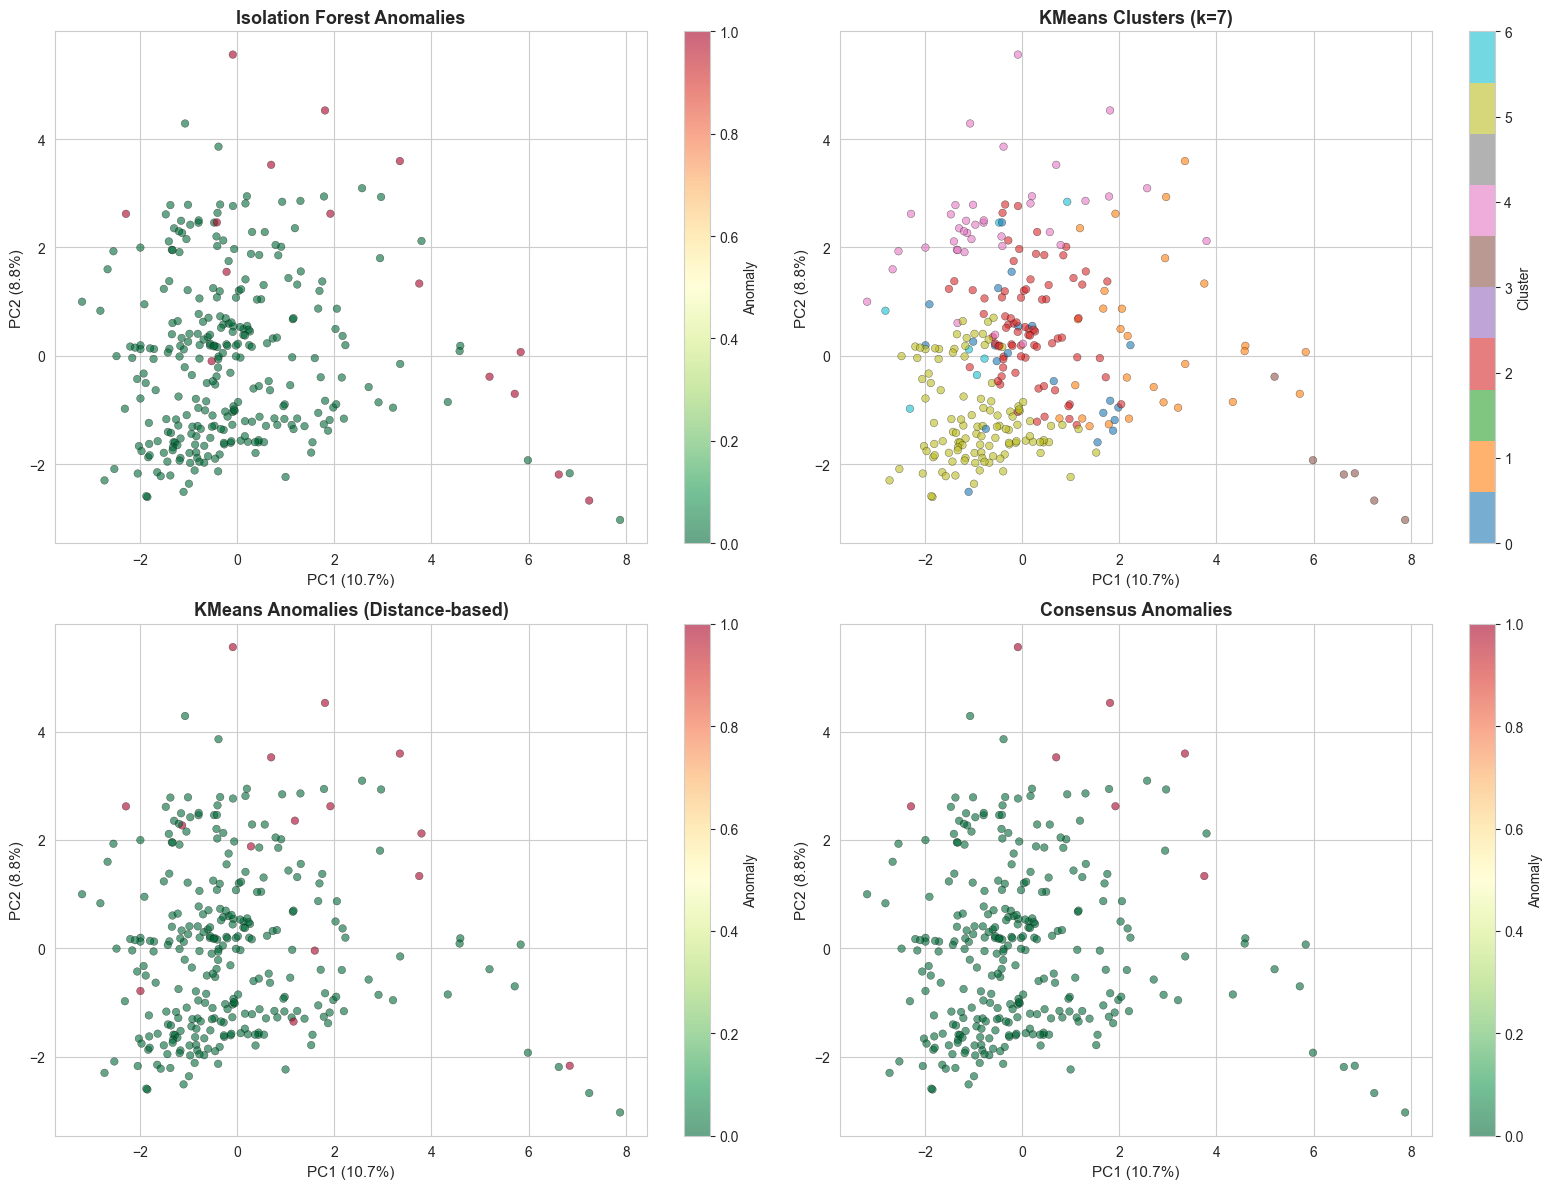

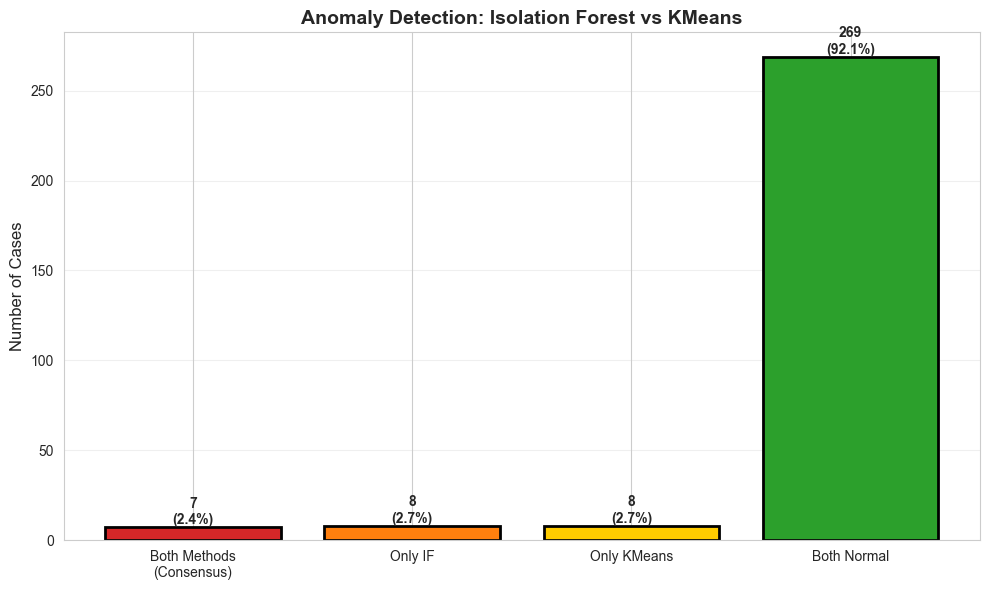


KMEANS CLUSTER PROFILING

📊 CLUSTER 0 (n=21):
  Anomalies in this cluster: 0
  Mean distance to centroid: 4.582
  time_in_hospital: mean=5.24
  num_lab_procedures: mean=58.71
  num_procedures: mean=0.95
  num_medications: mean=13.95

📊 CLUSTER 1 (n=28):
  Anomalies in this cluster: 4
  Mean distance to centroid: 4.716
  time_in_hospital: mean=6.21
  num_lab_procedures: mean=71.96
  num_procedures: mean=1.39
  num_medications: mean=21.71

📊 CLUSTER 2 (n=79):
  Anomalies in this cluster: 2
  Mean distance to centroid: 4.320
  time_in_hospital: mean=7.90
  num_lab_procedures: mean=71.22
  num_procedures: mean=1.14
  num_medications: mean=18.30

📊 CLUSTER 3 (n=6):
  Anomalies in this cluster: 1
  Mean distance to centroid: 5.439
  time_in_hospital: mean=5.67
  num_lab_procedures: mean=66.50
  num_procedures: mean=0.33
  num_medications: mean=18.83

📊 CLUSTER 4 (n=38):
  Anomalies in this cluster: 6
  Mean distance to centroid: 5.015
  time_in_hospital: mean=4.37
  num_lab_procedures: mean

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# =========================
# 1. LOAD DATA
# =========================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv("data/diabetic_data.csv")
print(f"Dataset shape: {df.shape}")

# =========================
# 2. FEATURE SELECTION
# =========================
print("\n" + "="*60)
print("FEATURE SELECTION FOR ANOMALY DETECTION")
print("="*60)

numeric_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

categorical_features = [
    "race", "gender", "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "change",
    "diabetesMed"
]

medication_features = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "glipizide", "glyburide", "pioglitazone",
    "rosiglitazone", "insulin"
]

all_features = numeric_features + categorical_features + medication_features

print(f"Total features: {len(all_features)}")

df_anomaly = df[all_features + ['readmitted', 'encounter_id', 'patient_nbr']].copy()

# =========================
# 3. PREPROCESSING
# =========================
print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

df_anomaly = df_anomaly.replace("?", np.nan)
initial_rows = len(df_anomaly)
df_anomaly = df_anomaly.dropna(subset=numeric_features + categorical_features)
print(f"Dropped {initial_rows - len(df_anomaly)} rows")
print(f"Final size: {df_anomaly.shape}")

# =========================
# 4. ENCODING
# =========================
print("\n" + "="*60)
print("ENCODING CATEGORICAL FEATURES")
print("="*60)

X_numeric = df_anomaly[numeric_features].copy()
X_categorical = df_anomaly[categorical_features].copy()
X_medications = df_anomaly[medication_features].copy()

X_categorical_encoded = X_categorical.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col].astype(str))
    label_encoders[col] = le

X_medications_encoded = X_medications.copy()
for col in medication_features:
    le = LabelEncoder()
    X_medications_encoded[col] = le.fit_transform(X_medications[col].astype(str))
    label_encoders[col] = le

X_combined = pd.concat([X_numeric, X_categorical_encoded, X_medications_encoded], axis=1)

# =========================
# 5. SCALING
# =========================
print("\n" + "="*60)
print("SCALING FEATURES")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
print(f"Scaled data shape: {X_scaled.shape}")

# =========================
# 6. ISOLATION FOREST
# =========================
print("\n" + "="*60)
print("ISOLATION FOREST ANOMALY DETECTION")
print("="*60)

contamination_rates = [0.01, 0.05, 0.10]
if_results = {}

for contamination in contamination_rates:
    print(f"\n--- Testing contamination={contamination} ---")
    
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100,
        max_samples='auto',
        n_jobs=-1
    )
    
    predictions = iso_forest.fit_predict(X_scaled)
    scores = iso_forest.score_samples(X_scaled)
    
    if_results[contamination] = {
        'model': iso_forest,
        'predictions': predictions,
        'scores': scores,
        'n_anomalies': np.sum(predictions == -1),
        'pct_anomalies': np.sum(predictions == -1) / len(predictions) * 100
    }
    
    print(f"Anomalies: {if_results[contamination]['n_anomalies']} ({if_results[contamination]['pct_anomalies']:.2f}%)")

optimal_contamination = 0.05
iso_forest = if_results[optimal_contamination]['model']
if_predictions = if_results[optimal_contamination]['predictions']
if_scores = if_results[optimal_contamination]['scores']

print(f"\n✅ Using contamination={optimal_contamination}")

# =========================
# 7. KMEANS CLUSTERING FOR ANOMALY DETECTION
# =========================
print("\n" + "="*60)
print("KMEANS CLUSTERING FOR ANOMALY DETECTION")
print("="*60)

# Find optimal number of clusters
k_range = range(3, 11)
silhouette_scores = []
inertias = []

print("\nFinding optimal k...")
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels_temp))
    inertias.append(kmeans_temp.inertia_)
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, Inertia={inertias[-1]:.0f}")

# Use k with best silhouette score or elbow method
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal k (by silhouette): {optimal_k}")

# Fit final KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_distances = kmeans.transform(X_scaled).min(axis=1)  # Distance to nearest centroid

print(f"Clusters found: {optimal_k}")
print(f"Cluster distribution:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

# =========================
# 8. DEFINE ANOMALIES BASED ON DISTANCE
# =========================
print("\n" + "="*60)
print("IDENTIFYING ANOMALIES FROM KMEANS")
print("="*60)

# Method 1: Use percentile threshold
percentile_thresholds = [95, 97, 99]
kmeans_results = {}

for percentile in percentile_thresholds:
    threshold = np.percentile(kmeans_distances, percentile)
    kmeans_anomaly = (kmeans_distances > threshold).astype(int)
    n_anomalies = kmeans_anomaly.sum()
    
    kmeans_results[percentile] = {
        'threshold': threshold,
        'predictions': kmeans_anomaly,
        'distances': kmeans_distances,
        'n_anomalies': n_anomalies,
        'pct_anomalies': n_anomalies / len(kmeans_distances) * 100
    }
    
    print(f"\nPercentile {percentile}%:")
    print(f"  Threshold: {threshold:.3f}")
    print(f"  Anomalies: {n_anomalies} ({n_anomalies/len(kmeans_distances)*100:.2f}%)")

# Use 95th percentile (approximately 5% anomaly rate)
optimal_percentile = 95
kmeans_threshold = kmeans_results[optimal_percentile]['threshold']
kmeans_anomaly = kmeans_results[optimal_percentile]['predictions']
kmeans_distances_final = kmeans_results[optimal_percentile]['distances']

print(f"\n✅ Using {optimal_percentile}th percentile threshold: {kmeans_threshold:.3f}")
print(f"Total anomalies (KMeans): {kmeans_anomaly.sum()}")

# =========================
# 9. ADD RESULTS TO DATAFRAME
# =========================
print("\n" + "="*60)
print("ADDING ANOMALY FLAGS")
print("="*60)

df_anomaly['if_prediction'] = if_predictions
df_anomaly['if_score'] = if_scores
df_anomaly['if_anomaly'] = (if_predictions == -1).astype(int)

df_anomaly['kmeans_cluster'] = kmeans_labels
df_anomaly['kmeans_distance'] = kmeans_distances_final
df_anomaly['kmeans_anomaly'] = kmeans_anomaly

# Consensus: both methods agree on anomaly
both_anomaly = (df_anomaly['if_anomaly'] == 1) & (df_anomaly['kmeans_anomaly'] == 1)
df_anomaly['consensus_anomaly'] = both_anomaly.astype(int)

# =========================
# 10. COMPARISON
# =========================
print("\n" + "="*60)
print("COMPARING ISOLATION FOREST vs KMEANS")
print("="*60)

only_if = (df_anomaly['if_anomaly'] == 1) & (df_anomaly['kmeans_anomaly'] == 0)
only_kmeans = (df_anomaly['if_anomaly'] == 0) & (df_anomaly['kmeans_anomaly'] == 1)
both_normal = (df_anomaly['if_anomaly'] == 0) & (df_anomaly['kmeans_anomaly'] == 0)

print(f"Both methods agree (Anomaly): {both_anomaly.sum()}")
print(f"Both methods agree (Normal): {both_normal.sum()}")
print(f"Only Isolation Forest: {only_if.sum()}")
print(f"Only KMeans: {only_kmeans.sum()}")
print(f"\nAgreement rate: {(both_anomaly.sum() + both_normal.sum()) / len(df_anomaly) * 100:.2f}%")

comparison_matrix = pd.DataFrame({
    'KMeans Normal': [both_normal.sum(), only_if.sum()],
    'KMeans Anomaly': [only_kmeans.sum(), both_anomaly.sum()]
}, index=['IF Normal', 'IF Anomaly'])

print("\nComparison Matrix:")
print(comparison_matrix)

# =========================
# 11. VISUALIZATIONS
# =========================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Score/Distance distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Isolation Forest scores
axes[0].hist(if_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=if_scores[if_predictions == -1].max(), 
                color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Isolation Forest Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# KMeans distances
axes[1].hist(kmeans_distances_final, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(x=kmeans_threshold, 
                color='red', linestyle='--', linewidth=2, 
                label=f'Anomaly Threshold ({optimal_percentile}th percentile)')
axes[1].set_xlabel('Distance to Nearest Centroid', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('KMeans Distance Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Elbow and Silhouette plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={optimal_k}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs k', fontsize=14, fontweight='bold')
axes[1].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={optimal_k}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# PCA Visualization
print("\nCreating PCA visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Isolation Forest anomalies
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=df_anomaly['if_anomaly'], 
                              cmap='RdYlGn_r', alpha=0.6, s=30,
                              edgecolors='black', linewidth=0.3)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0, 0].set_title('Isolation Forest Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0, 0], label='Anomaly')

# KMeans clusters
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=df_anomaly['kmeans_cluster'], 
                              cmap='tab10', alpha=0.6, s=30,
                              edgecolors='black', linewidth=0.3)
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0, 1].set_title(f'KMeans Clusters (k={optimal_k})', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# KMeans anomalies
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=df_anomaly['kmeans_anomaly'], 
                              cmap='RdYlGn_r', alpha=0.6, s=30,
                              edgecolors='black', linewidth=0.3)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1, 0].set_title('KMeans Anomalies (Distance-based)', fontsize=13, fontweight='bold')
plt.colorbar(scatter3, ax=axes[1, 0], label='Anomaly')

# Consensus anomalies
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=df_anomaly['consensus_anomaly'], 
                              cmap='RdYlGn_r', alpha=0.6, s=30,
                              edgecolors='black', linewidth=0.3)
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1, 1].set_title('Consensus Anomalies', fontsize=13, fontweight='bold')
plt.colorbar(scatter4, ax=axes[1, 1], label='Anomaly')

plt.tight_layout()
plt.show()

# Comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Both Methods\n(Consensus)', 'Only IF', 'Only KMeans', 'Both Normal']
counts = [both_anomaly.sum(), only_if.sum(), only_kmeans.sum(), both_normal.sum()]
colors = ['#d62728', '#ff7f0e', '#ffcc00', '#2ca02c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.set_title('Anomaly Detection: Isolation Forest vs KMeans', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df_anomaly)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# =========================
# 12. CLUSTER PROFILING
# =========================
print("\n" + "="*60)
print("KMEANS CLUSTER PROFILING")
print("="*60)

for cluster_id in range(optimal_k):
    cluster_data = df_anomaly[df_anomaly['kmeans_cluster'] == cluster_id]
    print(f"\n📊 CLUSTER {cluster_id} (n={len(cluster_data)}):")
    print(f"  Anomalies in this cluster: {cluster_data['kmeans_anomaly'].sum()}")
    print(f"  Mean distance to centroid: {cluster_data['kmeans_distance'].mean():.3f}")
    
    for feat in numeric_features[:4]:  # Show first 4 numeric features
        print(f"  {feat}: mean={cluster_data[feat].mean():.2f}")

# =========================
# 13. SUMMARY
# =========================
print("\n" + "="*60)
print("✨ ANOMALY DETECTION COMPLETE!")
print("="*60)
print(f"\n📊 Key Findings:")
print(f"  - Isolation Forest: {df_anomaly['if_anomaly'].sum():,} anomalies ({df_anomaly['if_anomaly'].mean()*100:.2f}%)")
print(f"  - KMeans: {df_anomaly['kmeans_anomaly'].sum():,} anomalies ({df_anomaly['kmeans_anomaly'].mean()*100:.2f}%)")
print(f"  - Consensus: {df_anomaly['consensus_anomaly'].sum():,} anomalies ({df_anomaly['consensus_anomaly'].mean()*100:.2f}%)")
print(f"  - Agreement rate: {(both_anomaly.sum() + both_normal.sum()) / len(df_anomaly) * 100:.2f}%")
print(f"  - Optimal k: {optimal_k} clusters")
print(f"  - Anomaly threshold: {kmeans_threshold:.3f} (distance to centroid)")